<a href="https://colab.research.google.com/github/LCaravaggio/politext/blob/main/LASSO_Senado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Base

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/kaggle.json", 'r') as f:
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d leonardocaravaggio/scraps-pdfs

Mounted at /content/drive
 99% 569M/573M [00:22<00:00, 31.3MB/s]
100% 573M/573M [00:22<00:00, 26.5MB/s]


In [3]:
import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

In [4]:
import pickle

with open('/content/vocabulary_senado.voc', 'rb') as f:
    inter = pickle.load(f)

In [5]:
import pandas as pd
base=pd.read_csv('/content/base_formateada.csv')

<ipython-input-5-71200aca493d>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  base=pd.read_csv('/content/base_formateada.csv')


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(2,2) ,vocabulary=inter)
matrix = cv.fit_transform(base['tokens'])

# Bases nuevas

In [7]:
# Esta celda tarda casi una hora en correr
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=30, max_iter=50, learning_method='batch', learning_offset=50.,random_state=0)
lda.fit(matrix)

LatentDirichletAllocation(learning_offset=50.0, max_iter=50, n_components=30,
                          random_state=0)

In [8]:
disc_weights=matrix*lda.components_.transpose()
base['Topic_weight']=disc_weights.argmax(axis=1)+1

In [9]:
disc_weights.shape

(156506, 30)

In [11]:
base.head(2)

,Unnamed: 0.1,Unnamed: 0,Nombre/Cargo,Discurso,Cargo,Nombre,Link,Legislatura,tipo,fecha,fecha_formato,nombre,apellidos,procedLiteral,procedLugar,grupoNombre,tokens,Topic_weight
0,0,0,El señor PRESIDENTE DE LA JUNTA PREPARATORIA (...,Se abre la sesión.,PRESIDENTE DE LA JUNTA PREPARATORIA,Alcalde Sánchez,https://www.senado.es/legis10/publicaciones/pd...,10,JUNTA PREPARATORIA Y SESIÓN CONSTITUTIVACORTES...,13 de diciembre de 2011,2011-12-13,GUSTAVO,ALCALDE SÁNCHEZ,Designado,Designado: Cortes de Aragón,GPP,['abr'],1
1,1,1,EL señor PRESIDENTE DE LA JUNTA PREPARATORIA (...,En cumplimiento de lo establecido en el aparta...,EL PRESIDENTE DE LA JUNTA PREPARATORIA,Alcalde Sánchez,https://www.senado.es/legis10/publicaciones/pd...,10,JUNTA PREPARATORIA Y SESIÓN CONSTITUTIVACORTES...,13 de diciembre de 2011,2011-12-13,GUSTAVO,ALCALDE SÁNCHEZ,Designado,Designado: Cortes de Aragón,GPP,"['cumplimiento', 'establecido', 'apartado', '2...",5


In [12]:
column_names = [str(i) for i in range(1, 31)]

df_weights = pd.DataFrame(disc_weights, columns=column_names)

select=[ 'fecha', 'apellidos', 'nombre' , 'Discurso'	, 'grupoNombre', 'Cargo']
df_weights = pd.concat([base[select], df_weights], axis=1)

In [14]:
df_weights.to_csv('df_weights_senado.csv')

In [15]:
import scipy as sp
from scipy.special import logsumexp

def frex(mod, w=0.7):
    log_beta = np.log(mod.components_)
    log_exclusivity = log_beta - logsumexp(log_beta, axis=0)
    exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
    freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
    out = 1. / (w / exclusivity_ecdf + (1 - w) / freq_ecdf)
    return out

def ecdf(arr):
    return sp.stats.rankdata(arr, method='max') / arr.size

In [16]:
import numpy as np
frex_df=pd.DataFrame(frex(lda))
disc_frex=matrix*frex_df.transpose()

In [17]:
df_frex = pd.DataFrame(disc_frex, columns=column_names)

df_frex = pd.concat([base[select], df_frex], axis=1)

In [18]:
df_frex.to_csv('df_frex_senado.csv')

# LASSO

In [20]:
base.grupoNombre.unique()

array(['GPP', 'GPS', 'GPCIU', 'GPMX', 'GPV', 'GPEPC', 'GPN', 'GPCDL',
       'GP', 'GPPOD', 'GPCs', 'GPIC', 'GPER', 'GPERB', 'GPPSI', 'GPD',
       'GS', 'GPSA', 'GPSV', 'GPUCD', 'GPCP', 'GSNV', 'GPCDIS', 'GPSNV',
       'GPCDS', 'GMX', 'GCDS', 'GCIU', 'GPECP', 'GPCC', 'GPSN'],
      dtype=object)

In [23]:
filtro = (base['grupoNombre'] == 'GPP') | (base['grupoNombre'] == 'GPS')
base = base[filtro]

In [24]:
base.grupoNombre.unique()

array(['GPP', 'GPS'], dtype=object)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from numpy import argsort

n=20
macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=50, solver='liblinear')
X_train, X_test, y_train, y_test = train_test_split(base.loc[:, base.columns != 'grupoNombre'], base['grupoNombre'], test_size=0.33, random_state=42)
train_matrix = cv.fit_transform(X_train['tokens'])
test_matrix = cv.transform(X_test['tokens'])
lr.fit(train_matrix,y_train)
predictions = lr.predict(test_matrix )
macro.append(f1_score(predictions,y_test, average='macro'))
weighted.append(f1_score(predictions,y_test, average='weighted'))

In [26]:
lasso=pd.DataFrame()
lasso['negativos']=cv.get_feature_names_out()[argsort(lr.coef_[0])[:20]]
lasso['positivos']=cv.get_feature_names_out()[argsort(lr.coef_[0])[-20:]]

In [27]:
lasso.to_csv('lasso_senado.csv')

# LASSO por legislatura

In [30]:
# Crear un diccionario de mapeo
mapeo = {
    '1/': 'I', '2/': 'II', '3/': 'III', '4/': 'IV', '5/': 'V', '6/': 'VI',
    '7/': 'VII', '8/': 'VIII', '9/': 'IX', 10: 'X', 11: 'XI',
    12: 'XII', 13: 'XIII', 14: 'XIV', '14': 'XIV'
}


base['Legislatura']=base['Legislatura'].replace(mapeo)

In [31]:
# Relevancia de bigramas en la predicción por legislatura
tabla=[]
legislaturas=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII','VIII', 'IX', 'X', 'XI', 'XII','XIII']
n=20

macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=50, solver='liblinear')

lasso=pd.DataFrame()

for x in legislaturas:
  base_year=base[base.Legislatura==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'grupoNombre'], base_year['grupoNombre'], test_size=0.33, random_state=42)
  train_matrix = cv.fit_transform(X_train['tokens'])
  test_matrix = cv.transform(X_test['tokens'])
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  macro.append(f1_score(predictions,y_test, average='macro'))
  weighted.append(f1_score(predictions,y_test, average='weighted'))
  s=lr.coef_[0]
  lasso[f"Legislatura: {x} - neg"] = cv.get_feature_names_out()[argsort(s)[:n]]
  lasso[f"Legislatura: {x} - pos"] = cv.get_feature_names_out()[argsort(s)[-n:]]

In [32]:
lasso.to_csv('lasso_por_legislatura_senado.csv')

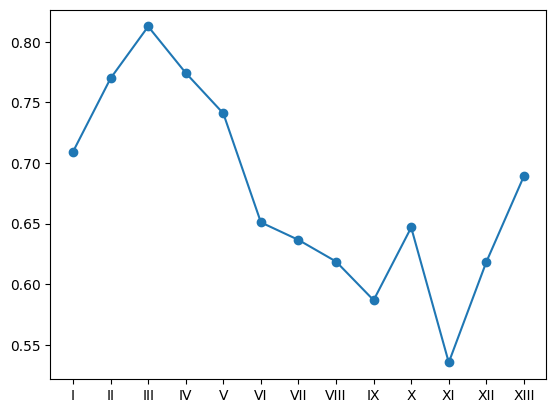

In [33]:
import matplotlib.pyplot as plt
plt.plot(legislaturas, macro, marker='o')
plt.savefig('lasso_por_legislatura_senado.png')

# LASSO por año

In [43]:
base.head(2)

,Unnamed: 0.1,Unnamed: 0,Nombre/Cargo,Discurso,Cargo,Nombre,Link,Legislatura,tipo,fecha,fecha_formato,nombre,apellidos,procedLiteral,procedLugar,grupoNombre,tokens,Topic_weight
0,0,0,El señor PRESIDENTE DE LA JUNTA PREPARATORIA (...,Se abre la sesión.,PRESIDENTE DE LA JUNTA PREPARATORIA,Alcalde Sánchez,https://www.senado.es/legis10/publicaciones/pd...,X,JUNTA PREPARATORIA Y SESIÓN CONSTITUTIVACORTES...,2011-12-13,2011-12-13,GUSTAVO,ALCALDE SÁNCHEZ,Designado,Designado: Cortes de Aragón,GPP,['abr'],1
1,1,1,EL señor PRESIDENTE DE LA JUNTA PREPARATORIA (...,En cumplimiento de lo establecido en el aparta...,EL PRESIDENTE DE LA JUNTA PREPARATORIA,Alcalde Sánchez,https://www.senado.es/legis10/publicaciones/pd...,X,JUNTA PREPARATORIA Y SESIÓN CONSTITUTIVACORTES...,2011-12-13,2011-12-13,GUSTAVO,ALCALDE SÁNCHEZ,Designado,Designado: Cortes de Aragón,GPP,"['cumplimiento', 'establecido', 'apartado', '2...",5


In [44]:
base.fecha=pd.to_datetime(base.fecha_formato, infer_datetime_format=True)

In [45]:
# Relevancia de bigramas en la predicción por año
macro=[]
weighted=[]

nombres=cv.get_feature_names_out()

n = 20
lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')


lasso=pd.DataFrame()

for x in range (1979, 2020):
  base_year=base[pd.DatetimeIndex(base.fecha).year==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'grupoNombre'], base_year['grupoNombre'], test_size=0.33, random_state=42)
  train_matrix = cv.fit_transform(X_train['tokens'])
  test_matrix = cv.transform(X_test['tokens'])
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  macro.append(f1_score(predictions,y_test, average='macro'))
  weighted.append(f1_score(predictions,y_test, average='weighted'))
  s = lr.coef_[0]
  lasso[f"Año: {x} - neg"] = cv.get_feature_names_out()[argsort(s)[:n]]
  lasso[f"Año: {x} - pos"] = cv.get_feature_names_out()[argsort(s)[-n:]]

In [46]:
lasso.to_csv('lasso_por_año_senado.csv')

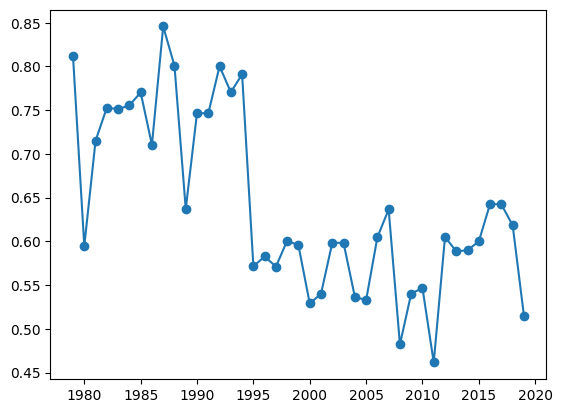

In [47]:
import matplotlib.pyplot as plt
plt.plot(range(1979,2020), macro, marker='o')
plt.savefig('lasso_por_año_senado.png')

# LASSO por Semana

In [48]:
len((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique())

796

In [49]:
base['semana']=pd.Series(pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).values

In [50]:
# Esta celda demora unos 25 minutos en correr
import numpy as np
lasso = pd.DataFrame(columns=[f"neg-{x}" for x in range(1, 21)] + [f"pos-{x}" for x in range(1, 21)], index=pd.Index((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str) + '-' + pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique(), name='semana'))
#lasso = pd.DataFrame(columns=[f"neg-{x}" for x in range(1, 21)] + [f"pos-{x}" for x in range(1, 21)], index=pd.Index(('1979-12','2019-35'), name='semana'))
macro=[]
weighted=[]

for x in lasso.index:
    try:
      base_semana = base[base['semana'] == x]
      X_train, X_test, y_train, y_test = train_test_split(base_semana.loc[:, base_semana.columns != 'grupoNombre'], base_semana['grupoNombre'], test_size=0.33, random_state=42)
      train_matrix = cv.fit_transform(X_train['tokens'])
      test_matrix = cv.transform(X_test['tokens'])
      lr.fit(train_matrix, y_train)
      predictions = lr.predict(test_matrix)
      s = lr.coef_[0]
      neg_features = cv.get_feature_names_out()[np.argsort(s)[:20]]
      pos_features = cv.get_feature_names_out()[np.argsort(s)[-20:]]
      lasso.loc[x, [f"neg-{i+1}" for i in range(20)]] = neg_features
      lasso.loc[x, [f"pos-{i+1}" for i in range(20)]] = pos_features

      predictions = lr.predict(test_matrix )
      macro.append(f1_score(predictions,y_test, average='macro'))
      weighted.append(f1_score(predictions,y_test, average='weighted'))
    except:
      macro.append(np.nan)
      weighted.append(np.nan)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [51]:
lasso.to_csv('lasso_por_semana_senado.csv')

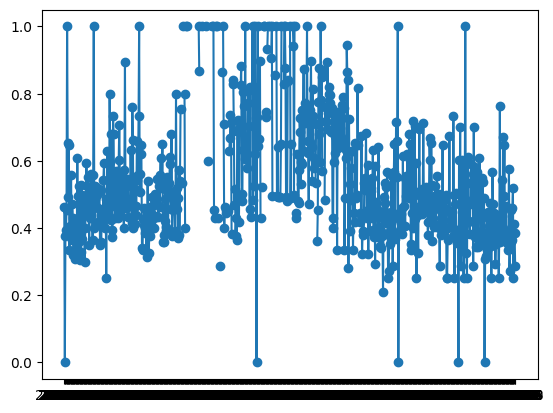

In [52]:
import matplotlib.pyplot as plt
plt.plot((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique(), macro, marker='o')

plt.savefig('lasso_por_semana_senado.png')

In [53]:
lasso['macro']=macro

In [54]:
# Estas son las semanas que tienen macro==1
lasso.index[lasso['macro'] == 1]

Index(['2012-11', '2014-25', '2019-4', '1979-25', '1979-37', '1979-40',
       '1980-25', '1980-39', '1981-10', '1981-41', '1981-48', '1982-8',
       '1982-9', '1983-5', '1984-40', '1985-17', '1985-24', '1985-43',
       '1986-42', '1986-44', '1987-10', '1987-18', '1987-25', '1987-48',
       '1988-19', '1988-38', '1988-39', '1989-10', '1989-21', '1989-30',
       '1991-7', '1992-20', '2000-14', '2006-15'],
      dtype='object', name='semana')

In [55]:
# Una sola semana tiene macro==0
lasso.index[lasso['macro'] == 0]

Index(['2012-4', '1985-39', '2000-19', '2005-43', '2008-14'], dtype='object', name='semana')

In [56]:
base[base.semana=='1981-1']

,Unnamed: 0.1,Unnamed: 0,Nombre/Cargo,Discurso,Cargo,Nombre,Link,Legislatura,tipo,fecha,fecha_formato,nombre,apellidos,procedLiteral,procedLugar,grupoNombre,tokens,Topic_weight,semana


In [57]:
# Estas son las semanas en las que el macro es > 0.8
lasso.index[lasso['macro'] > 0.8]

Index(['2012-11', '2014-25', '2017-45', '2019-4', '1979-25', '1979-37',
       '1979-40', '1980-25', '1980-26', '1980-39', '1981-10', '1981-41',
       '1981-48', '1982-8', '1982-9', '1982-30', '1983-5', '1983-42',
       '1983-45', '1984-19', '1984-21', '1984-26', '1984-40', '1984-51',
       '1985-9', '1985-16', '1985-17', '1985-21', '1985-24', '1985-43',
       '1986-7', '1986-42', '1986-44', '1987-7', '1987-10', '1987-18',
       '1987-21', '1987-25', '1987-44', '1987-48', '1988-19', '1988-28',
       '1988-38', '1988-39', '1988-42', '1988-50', '1988-51', '1989-10',
       '1989-21', '1989-25', '1989-30', '1990-40', '1991-7', '1991-23',
       '1991-39', '1992-14', '1992-20', '1992-24', '1992-28', '1992-48',
       '1993-6', '1994-46', '1994-48', '1994-51', '1995-51', '2000-14',
       '2006-15'],
      dtype='object', name='semana')

# Asignacion de Topic por semana

In [58]:
import statistics as st
a=[]
for x in lasso.index:
      a.append(st.mode(base[base['semana'] == x]['Topic_weight']))

In [59]:
topic_semana=pd.DataFrame(lasso['macro'])

In [60]:
topic_semana['topic']=a

In [61]:
topic_semana.to_csv('topic_por_semana_senado.csv')

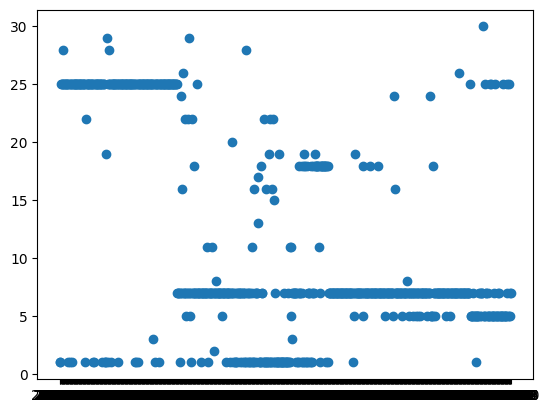

In [62]:
import matplotlib.pyplot as plt
plt.scatter((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique(), topic_semana['topic'], marker='o')
plt.savefig('topic_por_semana_senado.png')

In [63]:
# Estas son las semanas en las que se habló de temas distintos al Topic 1.
topic_semana.index[topic_semana['topic'] != 1]

Index(['2012-6', '2012-8', '2012-10', '2012-11', '2012-13', '2012-15',
       '2012-17', '2012-19', '2012-21', '2012-23',
       ...
       '2010-27', '2010-29', '2010-37', '2010-38', '2010-40', '2010-42',
       '2010-44', '2010-46', '2010-48', '2010-50'],
      dtype='object', name='semana', length=693)

# Mes

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from numpy import argsort
import numpy as np

In [65]:
base['fecha'] = pd.to_datetime(base['fecha'])
base['mes'] = base['fecha'].dt.strftime('%Y-%m')

In [66]:
meses=sorted(base.mes.unique(), key=lambda x: (int(x.split('-')[0]), int(x.split('-')[1])))

In [83]:
base.mes[1]

'2011-12'

In [84]:
meses[1]

'1979-06'

In [86]:
# Relevancia de bigramas en la predicción por mes
macro = []
weighted = []

nombres = cv.get_feature_names_out()

n = 20
lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

lasso_neg = []
lasso_pos = []

for x in meses:
    m=np.nan
    base_mes = base[base.mes == x]
    X_train, X_test, y_train, y_test = train_test_split(
        base_mes.loc[:, base_mes.columns != 'grupoNombre'],
        base_mes['grupoNombre'],
        test_size=0.33,
        random_state=12
    )
    train_matrix = cv.fit_transform(X_train['tokens'])
    test_matrix = cv.transform(X_test['tokens'])

    try:
      lr.fit(train_matrix, y_train)
      predictions = lr.predict(test_matrix)
      m=f1_score(predictions, y_test, average='macro')
      weighted.append(f1_score(predictions, y_test, average='weighted'))
      s = lr.coef_[0]
      lasso[f"Mes: {x} - neg"] = cv.get_feature_names_out()[argsort(s)[:n]]
      lasso[f"Mes: {x} - pos"] = cv.get_feature_names_out()[argsort(s)[-n:]]
    except:
      lasso[f"Mes: {x} - neg"] = np.nan
      lasso[f"Mes: {x} - pos"] = np.nan

    macro.append(m)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [89]:
lasso.to_csv('lasso_por_mes_senado.csv')

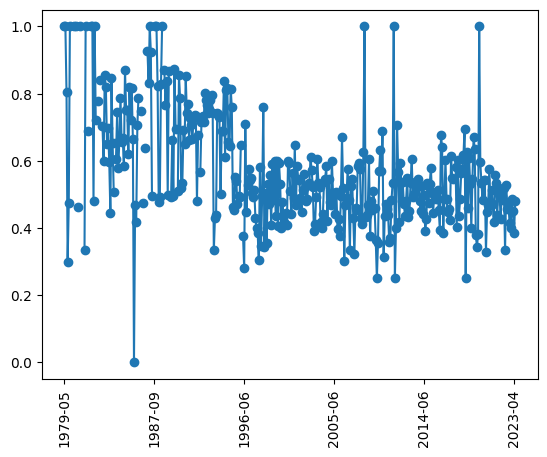

In [92]:
import matplotlib.pyplot as plt
plt.plot(meses, macro, marker='o')

selected_indices = [0, 80, 160, 240, 320, 400]
selected_labels = [meses[i] for i in selected_indices]
plt.xticks(selected_indices, selected_labels, rotation=90)

plt.savefig('lasso_por_mes_senado.png')

# Bajada

In [94]:
from google.colab import files
files.download('df_frex_senado.csv')
files.download('df_weights_senado.csv')

files.download('/content/lasso_por_año_senado.csv')
files.download('/content/lasso_por_año_senado.png')

files.download('/content/lasso_por_legislatura_senado.csv')
files.download('/content/lasso_por_legislatura_senado.png')

files.download('/content/lasso_por_mes_senado.csv')
files.download('/content/lasso_por_mes_senado.png')

files.download('/content/lasso_por_semana_senado.csv')
files.download('/content/lasso_por_semana_senado.png')

files.download('/content/topic_por_semana_senado.csv')
files.download('/content/topic_por_semana_senado.png')

files.download('/content/lasso_senado.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>